In [2]:
import itertools as it
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

from datetime import datetime, timedelta
from load_data import load_data
from matplotlib.ticker import StrMethodFormatter
from settings import config
from summary_stats import summary_stats
from tqdm import tqdm

# Get the data directory from the configuration
DATA_DIR = config("DATA_DIR")

In [3]:
pd.set_option('display.float_format', '{:.2f}'.format)

# Initial Variables

In [4]:
TICKERS = ["BTC-USD"]
MA_DAYS = [28]
INITIAL_CAPITAL = 10_000
RSI_PERIOD = 14
RSI_THRESHOLD = 30
TRAILING_STOP_PCT = 0.02
START_DATE = "2025-06-30"
END_DATE = "2025-07-31"

In [5]:
def load_crypto_data(
    tickers: list,
    base_directory,
    start_date: str,
    end_date: str,
) -> dict:
    """
    Loads minute-level data for multiple crypto tickers from Coinbase source.

    Parameters:
    - tickers: list of strings, e.g., ["BTC-USD", "ETH-USD", "SOL-USD"]
    - base_directory: path to your data directory (from config)
    - start_date: optional string, e.g., "2023-01-01"
    - end_date: optional string, e.g., "2023-12-31"

    Returns:
    - dict of DataFrames keyed by ticker
    """
    data = {}
    for ticker in tickers:
        df = load_data(
            base_directory=base_directory,
            ticker=ticker,
            source="Coinbase",
            asset_class="Cryptocurrencies",
            timeframe="Minute",
            file_format="pickle",
        )
        df.index = pd.to_datetime(df.index)
        df = df.sort_index()

        # Apply date filtering if specified
        if start_date:
            df = df[df.index >= pd.to_datetime(start_date)]
        if end_date:
            df = df[df.index <= pd.to_datetime(end_date)]

        data[ticker] = df

    return data

crypto_data = load_crypto_data(
    tickers=TICKERS,
    base_directory=DATA_DIR,
    start_date=START_DATE,
    end_date=END_DATE,
)

crypto_data

{'BTC-USD':                           low      high      open     close  volume
 Date                                                               
 2025-06-30 00:00:00 108341.37 108450.00 108386.44 108355.95    9.59
 2025-06-30 00:01:00 108318.32 108362.27 108357.96 108333.11    1.47
 2025-06-30 00:02:00 108282.11 108333.10 108333.10 108328.91    1.44
 2025-06-30 00:03:00 108303.01 108347.37 108327.79 108314.29    2.81
 2025-06-30 00:04:00 108306.85 108327.96 108314.28 108309.90    1.80
 ...                       ...       ...       ...       ...     ...
 2025-07-30 23:56:00 117856.59 117880.00 117856.59 117867.34    0.27
 2025-07-30 23:57:00 117836.00 117867.37 117867.35 117836.00    1.36
 2025-07-30 23:58:00 117829.75 117836.01 117836.00 117830.15    0.70
 2025-07-30 23:59:00 117830.14 117830.15 117830.15 117830.15    0.78
 2025-07-31 00:00:00 117830.15 117869.50 117830.15 117833.75    1.23
 
 [44641 rows x 5 columns]}

In [6]:
def calculate_rsi(prices: pd.Series, period: int = 14) -> pd.Series:
    """Calculates the Relative Strength Index (RSI) for a price series."""
    delta = prices.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    avg_gain = gain.ewm(alpha=1/period, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/period, adjust=False).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def prepare_crypto_indicators(
    data: dict,
    rsi_period: int = 14,
    ma_days: list = [7, 14, 21, 28, 35, 42, 49, 56, 63, 70]
) -> dict:
    """
    Adds RSI and daily moving averages to each crypto DataFrame.

    Parameters:
    - data: dict of DataFrames keyed by ticker
    - rsi_period: RSI lookback (default=14)
    - ma_days: list of MA durations (in days) for trend allocation

    Returns:
    - dict of enriched DataFrames with 'RSI' and MA columns
    """
    enriched_data = {}

    for ticker, df in data.items():
        df = df.copy()
        df["RSI"] = calculate_rsi(df["close"], period=rsi_period)

        for day in ma_days:
            window = 1440 * day  # 1440 minutes in a day
            df[f"MA_{day}d"] = df["close"].rolling(window=window, min_periods=1).mean()

        enriched_data[ticker] = df

    return enriched_data

enriched_data = prepare_crypto_indicators(
    data=crypto_data,
    rsi_period=RSI_PERIOD,
    ma_days=MA_DAYS,
)

enriched_data

{'BTC-USD':                           low      high      open     close  volume   RSI  \
 Date                                                                        
 2025-06-30 00:00:00 108341.37 108450.00 108386.44 108355.95    9.59   NaN   
 2025-06-30 00:01:00 108318.32 108362.27 108357.96 108333.11    1.47  0.00   
 2025-06-30 00:02:00 108282.11 108333.10 108333.10 108328.91    1.44  0.00   
 2025-06-30 00:03:00 108303.01 108347.37 108327.79 108314.29    2.81  0.00   
 2025-06-30 00:04:00 108306.85 108327.96 108314.28 108309.90    1.80  0.00   
 ...                       ...       ...       ...       ...     ...   ...   
 2025-07-30 23:56:00 117856.59 117880.00 117856.59 117867.34    0.27 63.14   
 2025-07-30 23:57:00 117836.00 117867.37 117867.35 117836.00    1.36 58.16   
 2025-07-30 23:58:00 117829.75 117836.01 117836.00 117830.15    0.70 57.25   
 2025-07-30 23:59:00 117830.14 117830.15 117830.15 117830.15    0.78 57.25   
 2025-07-31 00:00:00 117830.15 117869.50 117830.15 11

In [6]:
def backtest_rsi_multi_asset_strategy(
    data: dict,
    initial_capital: float,
    rsi_threshold: float,
    trailing_stop_pct: float,
    ma_days: list,
) -> pd.DataFrame:
    """
    Multi-asset backtest using RSI threshold + MA filter + trailing stop.
    
    Capital is shared across all assets. Each asset trades independently.

    Parameters:
    - data: dict of enriched DataFrames keyed by asset symbol (must have RSI and MA columns)
    - initial_capital: starting cash
    - rsi_threshold: RSI entry trigger (e.g., 30)
    - trailing_stop_pct: trailing stop trigger (e.g., 0.02)
    - ma_days: list of moving average day lengths

    Returns:
    - DataFrame of all trades across assets
    """
    # Merge index across all assets
    all_timestamps = sorted(set().union(*[df.index for df in data.values()]))
    
    # Initialize tracking variables
    cash = initial_capital

    # Create list for trades
    trades = []

    # Create dictionary to hold positions
    positions = {symbol: None for symbol in data}

    for timestamp in all_timestamps:
        for symbol, df in data.items():
            if timestamp not in df.index:
                continue

            row = df.loc[timestamp]
            position = positions[symbol]

            # Index of current bar; need previous bar for signals
            i = df.index.get_loc(timestamp)
            if i == 0:
                continue
            prev = df.iloc[i - 1]

            # --- ENTRY ---
            if position is None:
                # FIX: use previous-bar RSI (already did) AND previous-bar MA/close to avoid look-ahead
                prev_rsi = prev.get("RSI", float("nan"))
                if pd.isna(prev_rsi):
                    continue

                
                if prev_rsi < rsi_threshold:
                    # FIX: use previous close vs previous MA values
                    if any(pd.isna(prev.get(f"MA_{day}d", float("nan"))) for day in ma_days):
                        continue
                    ma_passes = sum(prev["close"] > prev[f"MA_{day}d"] for day in ma_days)
                    allocation_pct = ma_passes / len(ma_days)
                    if allocation_pct <= 0:
                        continue

                    # capital_to_use = cash * allocation_pct
                    capital_to_use = cash * allocation_pct / len(TICKERS)
                    if capital_to_use <= 0:
                        continue

                    entry_price = row["open"]  # execute at current open
                    if entry_price <= 0:
                        continue

                    quantity = capital_to_use / entry_price

                    positions[symbol] = {
                        "entry_time": timestamp,
                        "entry_price": float(entry_price),
                        "peak_price": float(entry_price),
                        "quantity": float(quantity),
                        "allocation_pct": float(allocation_pct),
                    }
                    cash -= quantity * entry_price

            # --- EXIT ---
            else:
                # Update peak with current bar high
                peak_price = max(position["peak_price"], row["high"])
                stop_price = peak_price * (1 - trailing_stop_pct)

                # Did price breach the stop this bar?
                if row["low"] <= stop_price:
                    # FIX: gap handling — if open < stop, assume fill at open; else at stop
                    if row["open"] < stop_price:
                        exit_price = row["open"]
                    else:
                        exit_price = stop_price

                    quantity = position["quantity"]
                    pnl = quantity * (exit_price - position["entry_price"])
                    return_dec = (exit_price - position["entry_price"]) / position["entry_price"]

                    cash += quantity * exit_price

                    trades.append({
                        "asset": symbol,
                        "entry_time": position["entry_time"],
                        "exit_time": timestamp,
                        "entry_price": position["entry_price"],
                        "exit_price": exit_price,
                        "quantity": quantity,
                        "allocation_pct": position["allocation_pct"],
                        "pnl": pnl,
                        "return_dec": return_dec,  # FIX: keep as decimal; format later
                        "cash": cash,
                    })

                    positions[symbol] = None
                else:
                    # carry forward higher peak
                    positions[symbol]["peak_price"] = peak_price

                    # Create new dataframe for trades
    trades_df = pd.DataFrame(trades)

    # If there are entries, calc cumulative pnl, equity, cumulative return
    if not trades_df.empty:
        trades_df["cumulative_pnl"] = trades_df["pnl"].cumsum()
        trades_df["equity"] = trades_df["cumulative_pnl"] + initial_capital
        trades_df["cumulative_return"] = trades_df["equity"] / initial_capital - 1

    return trades_df

trades_df = backtest_rsi_multi_asset_strategy(
    data=enriched_data,
    initial_capital=INITIAL_CAPITAL,
    rsi_threshold=RSI_THRESHOLD,
    trailing_stop_pct=TRAILING_STOP_PCT,
    ma_days=MA_DAYS,
)

trades_df

,asset,entry_time,exit_time,entry_price,exit_price,quantity,allocation_pct,pnl,return_dec,cash,cumulative_pnl,equity,cumulative_return
0,BTC-USD,2025-06-30 00:06:00,2025-07-01 09:20:00,108351.98,106624.00,0.09,1.00,-159.48,-0.02,9840.52,-159.48,9840.52,-0.02
1,BTC-USD,2025-07-02 11:33:00,2025-07-04 13:34:00,107712.82,108378.20,0.09,1.00,60.79,0.01,9901.31,-98.69,9901.31,-0.01
2,BTC-USD,2025-07-04 13:49:00,2025-07-07 18:29:00,108249.25,107546.81,0.09,1.00,-64.25,-0.01,9837.06,-162.94,9837.06,-0.02
3,BTC-USD,2025-07-08 08:37:00,2025-07-14 14:42:00,108324.14,120766.45,0.09,1.00,1129.90,0.11,10966.96,966.96,10966.96,0.10
4,BTC-USD,2025-07-14 14:43:00,2025-07-15 01:22:00,120781.78,118781.93,0.09,1.00,-181.59,-0.02,10785.38,785.38,10785.38,0.08
5,BTC-USD,2025-07-15 01:23:00,2025-07-15 03:20:00,118777.66,117106.34,0.09,1.00,-151.76,-0.01,10633.62,633.62,10633.62,0.06
6,BTC-USD,2025-07-15 03:38:00,2025-07-15 14:54:00,116989.68,116095.06,0.09,1.00,-81.31,-0.01,10552.30,552.30,10552.30,0.06
7,BTC-USD,2025-07-15 14:55:00,2025-07-17 01:50:00,116061.39,117732.10,0.09,1.00,151.90,0.01,10704.20,704.20,10704.20,0.07
8,BTC-USD,2025-07-17 03:19:00,2025-07-18 08:41:00,117947.84,118578.78,0.09,1.00,57.26,0.01,10761.46,761.46,10761.46,0.08
9,BTC-USD,2025-07-18 08:42:00,2025-07-18 19:03:00,118543.93,117194.82,0.09,1.00,-122.47,-0.01,10638.99,638.99,10638.99,0.06


In [7]:
def compute_daily_performance(
    trades_df: pd.DataFrame,
    data: dict,
    initial_capital=INITIAL_CAPITAL,
) -> pd.DataFrame:
    
    """
    Computes daily portfolio equity and return from multi-asset trades and prices.

    Parameters:
    - trades: DataFrame of trades from backtest_rsi_multi_asset_strategy
    - data: dict of price DataFrames per asset (with 'close'), indexed by datetime

    Returns:
    - DataFrame indexed by date with:
        - equity
        - cash
        - daily_return
        - cumulative_return
        - [position_{asset}]
        - [price_{asset}]
    """

    # Filter the entry trades
    entry_trades_df = trades_df.copy()
    entry_trades_df = entry_trades_df[['asset', 'entry_time', 'entry_price', 'quantity']]
    entry_trades_df['cash'] = entry_trades_df['entry_price'] * entry_trades_df['quantity'] * -1
    entry_trades_df['crypto_value'] = entry_trades_df['quantity'] * entry_trades_df['entry_price']
    entry_trades_df.rename(columns={'entry_time': 'Date'}, inplace=True)

    # Filter the exit trades
    exit_trades_df = trades_df.copy()
    exit_trades_df = exit_trades_df[['asset', 'exit_time', 'exit_price', 'quantity']]
    exit_trades_df['cash'] = exit_trades_df['exit_price'] * exit_trades_df['quantity']
    exit_trades_df['quantity'] = exit_trades_df['quantity'] * -1  # Convert quantity to negative for exit
    exit_trades_df['crypto_value'] = exit_trades_df['quantity'] * exit_trades_df['exit_price']
    exit_trades_df.rename(columns={'exit_time': 'Date'}, inplace=True)

    # Combine entry and exit trades into a single DataFrame
    ledger_events_df = pd.concat([entry_trades_df, exit_trades_df], ignore_index=True)
    ledger_events_df = ledger_events_df.sort_values('Date')

    # Create pivot table for quantity held by date per asset
    quantity_df = ledger_events_df.pivot_table(
        index='Date',
        columns='asset',
        values='quantity',
        aggfunc='sum',
    ).fillna(0)

    quantity_df.columns = [f"{col}_qty" for col in quantity_df.columns]

    # Cash flow dataframe
    cash_df = ledger_events_df.groupby('Date')['cash'].sum().to_frame()

    # Combine quantity and cash dataframes into the ledger
    ledger_qtys_df = pd.concat([quantity_df, cash_df], axis=1).fillna(0)
    ledger_qtys_df = ledger_qtys_df.sort_index()

    # Create list for daily prices
    daily_prices = []

    # Rename the 'close' column to include the ticker and add DataFrame to the list
    for ticker, df in data.items():
        daily_close = df["close"].to_frame(name=f"{ticker}_close")
        daily_prices.append(daily_close)

    # Merge all daily prices into a single DataFrame
    price_df = pd.concat(daily_prices, axis=1)

    # Merge the daily close prices DataFrame into the ledger
    ledger_qtys_prices_df = ledger_qtys_df.merge(price_df, left_index=True, right_index=True, how="outer")
    ledger_qtys_prices_df.reset_index(inplace=True)
    ledger_qtys_prices_df.rename(columns={'index': 'Date'}, inplace=True)

    # Replace all NaN values with 0
    ledger_qtys_prices_df.fillna(0, inplace=True)

    # Add columns for each asset's cumulative quantity
    quantity_cols = [col for col in ledger_qtys_prices_df.columns if col.endswith("_qty")]
    for col in quantity_cols:
        ledger_qtys_prices_df[col] = ledger_qtys_prices_df[col].cumsum()

    # Cumulative cash column
    ledger_qtys_prices_df['cash'] = ledger_qtys_prices_df['cash'].cumsum()

    # Add initial capital amount to cash to represent initial capital
    ledger_qtys_prices_df['cash'] += initial_capital

    # Establish position columns for each asset
    ledger_qtys_prices_pos_df = ledger_qtys_prices_df.copy()
    for col in quantity_cols:
        asset_symbol = col.replace("_qty", "")
        ledger_qtys_prices_pos_df[f"{asset_symbol}_position"] = ledger_qtys_prices_pos_df[col] * ledger_qtys_prices_pos_df[f"{asset_symbol}_close"]

    # Re-arrange the columns to have date, cash, then quantities, prices, positions grouped by asset
    asset_symbols = []
    for col in quantity_cols:
        asset_symbol = col.replace("_qty", "")
        asset_symbols.append(asset_symbol)

    cols = (['Date', 'cash'] + [col for ticker in asset_symbols for col in ledger_qtys_prices_pos_df.columns if col.startswith(ticker)])
    ledger_qtys_prices_pos_df = ledger_qtys_prices_pos_df[cols]

    # Calculate total portfolio value
    ledger_qtys_prices_pos_df['equity'] = ledger_qtys_prices_pos_df['cash'] + ledger_qtys_prices_pos_df[[col for col in ledger_qtys_prices_pos_df.columns if col.endswith('_position')]].sum(axis=1)

    # Set the 'Date' column as the index
    ledger_qtys_prices_pos_df = ledger_qtys_prices_pos_df.set_index('Date')

    # Reindex ledger to daily using last price for the day
    daily_ledger_qtys_prices_pos_df = ledger_qtys_prices_pos_df.copy()
    daily_ledger_qtys_prices_pos_df = daily_ledger_qtys_prices_pos_df.resample("D").last()

    # Drop the columns where any of the crypto asset prices = 0
    price_cols = [col for col in daily_ledger_qtys_prices_pos_df.columns if col.endswith("_close")]
    complete_ledger = daily_ledger_qtys_prices_pos_df[~(daily_ledger_qtys_prices_pos_df[price_cols] == 0).any(axis=1)]

    # Calculate crypto daily return, cumulative return, and drawdown
    for col in asset_symbols:
        complete_ledger[f"{col}_return"] = complete_ledger[f"{col}_close"].pct_change()
        complete_ledger[f"{col}_cum_return"] = (1 + complete_ledger[f"{col}_return"]).cumprod() - 1
        complete_ledger[f"{col}_drawdown"] = (complete_ledger[f"{col}_close"] - complete_ledger[f"{col}_close"].cummax()) / complete_ledger[f"{col}_close"].cummax()

    # Calculate portfolio daily return and cumulative return
    complete_ledger['Return'] = complete_ledger['equity'].pct_change()
    complete_ledger['Cum_Return'] = (1 + complete_ledger['Return']).cumprod() - 1

    # Calculate drawdown
    complete_ledger["Drawdown"] = (complete_ledger["equity"] - complete_ledger["equity"].cummax()) / complete_ledger["equity"].cummax()

    return complete_ledger

daily_perf_df = compute_daily_performance(
    trades_df=trades_df,
    data=enriched_data,
    initial_capital=INITIAL_CAPITAL,
)

daily_perf_df

,cash,BTC-USD_qty,BTC-USD_close,BTC-USD_position,equity,BTC-USD_return,BTC-USD_cum_return,BTC-USD_drawdown,Return,Cum_Return,Drawdown
Date,,,,,,,,,,,
2025-06-30,0.00,0.09,107173.21,9891.21,9891.21,NaN,NaN,0.00,NaN,NaN,0.00
2025-07-01,9840.52,0.00,105711.78,0.00,9840.52,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01
2025-07-02,0.00,0.09,108888.32,9947.91,9947.91,0.03,0.02,0.00,0.01,0.01,0.00
2025-07-03,0.00,0.09,109628.83,10015.57,10015.57,0.01,0.02,0.00,0.01,0.01,0.00
2025-07-04,0.00,0.09,108028.60,9881.13,9881.13,-0.01,0.01,-0.01,-0.01,-0.00,-0.01
2025-07-05,0.00,0.09,108246.65,9901.07,9901.07,0.00,0.01,-0.01,0.00,0.00,-0.01
2025-07-06,0.00,0.09,109217.98,9989.92,9989.92,0.01,0.02,-0.00,0.01,0.01,-0.00
2025-07-07,9837.06,0.00,108269.84,0.00,9837.06,-0.01,0.01,-0.01,-0.02,-0.01,-0.02
2025-07-08,0.00,0.09,108958.04,9894.62,9894.62,0.01,0.02,-0.01,0.01,0.00,-0.01


# Summary Stats

In [8]:
sum_stats_df = summary_stats(
    fund_list=TICKERS,
    df=daily_perf_df[['Return']],
    period="Daily",
    use_calendar_days=True,
    excel_export=False,
    pickle_export=False,
    output_confirmation=True,
)

sum_stats_df

Summary stats complete for BTC-USD


,Annualized Mean,Annualized Volatility,Annualized Sharpe Ratio,CAGR,Daily Max Return,Daily Max Return (Date),Daily Min Return,Daily Min Return (Date),Max Drawdown,Peak,Trough,Recovery Date
Return,0.67,0.24,2.82,0.86,0.04,2025-07-10,-0.02,2025-07-15,-0.04,2025-07-14,2025-07-30,NaT


# Plots

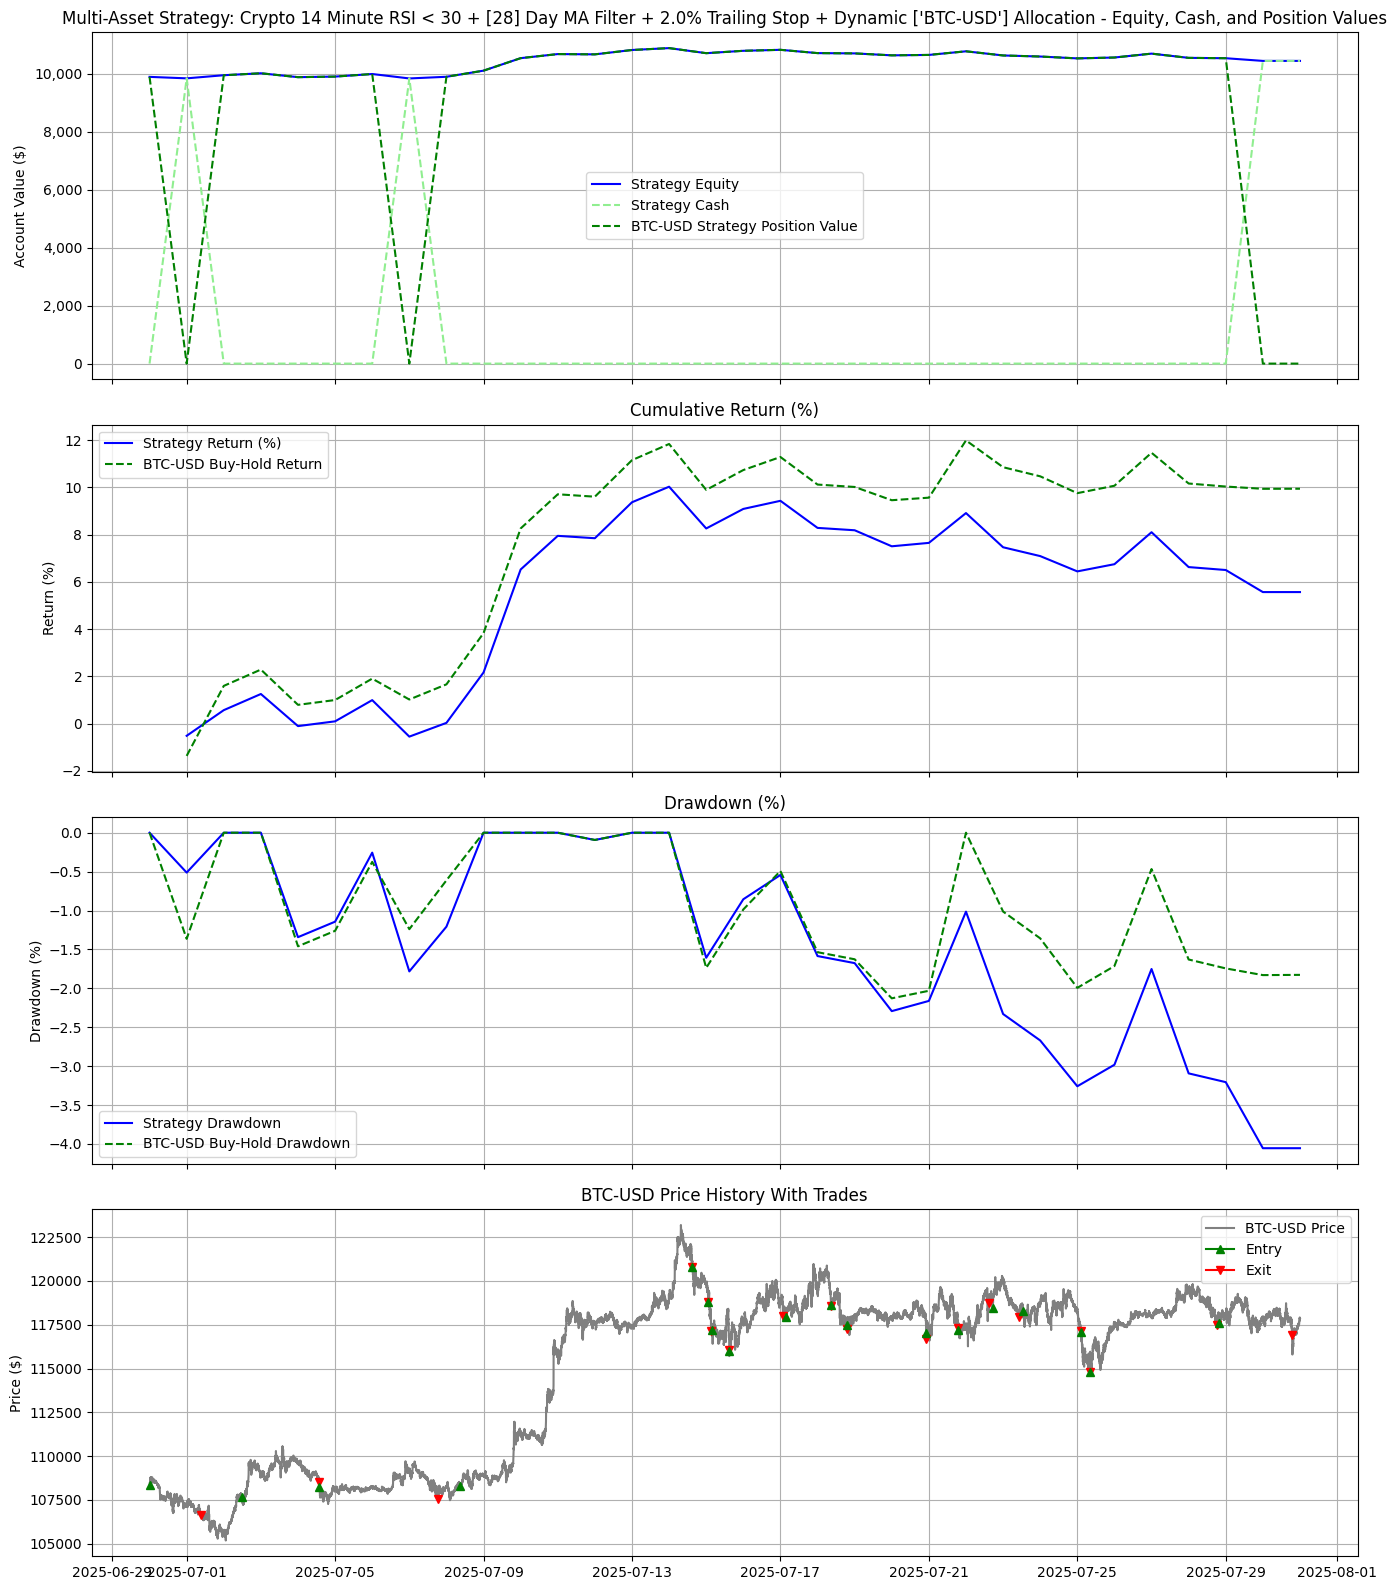

In [9]:
def plot_multi_asset_equity_and_drawdown(
    perf_df: pd.DataFrame,
    trades_df: pd.DataFrame,
    data: dict,
    title: str,
) -> None:
    """
    Plots:
    - Total equity, cash, and per-asset position values
    - Cumulative returns (strategy and crypto assets)
    - Drawdowns (strategy and crypto assets)
    - Price series and trade markers for BTC, ETH, SOL
    """


    # Identify asset symbols
    qty_cols = [col for col in perf_df.columns if col.endswith("_qty")]
    asset_symbols = [col.replace("_qty", "") for col in qty_cols]

    # Compute position values and crypto drawdowns
    colors = ["green", "red", "purple", "orange", "yellow"]

    # Determine number of subplots
    n_fixed = 3  # ax1, ax2, ax3
    n_tickers = len(TICKERS)
    total_axes = n_fixed + n_tickers

    # Setup plot
    fig, axes = plt.subplots(
        total_axes, 1,
        figsize=(14, 4 * total_axes),
        sharex=True,
        gridspec_kw={"height_ratios": [1] * total_axes}
    )

    # Unpack fixed axes
    ax1, ax2, ax3 = axes[:3]

    # Assign price axes
    price_axes = axes[3:]

    # ax1: Equity, Cash, and Position Values
    ax1.plot(perf_df.index, perf_df["equity"], color="blue", label="Strategy Equity")
    ax1.plot(perf_df.index, perf_df["cash"], color="lightgreen", linestyle="--", label="Strategy Cash")
    # for i, symbol in enumerate(asset_symbols):
    for i, symbol in enumerate(TICKERS):
        ax1.plot(perf_df.index, perf_df[f"{symbol}_position"], linestyle="--", color=colors[i % len(colors)], label=f"{symbol} Strategy Position Value")
    ax1.set_title(f"{title} - Equity, Cash, and Position Values")
    ax1.yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
    ax1.set_ylabel("Account Value ($)")
    ax1.legend()
    ax1.grid(True)

    # ax2: Cumulative Returns
    ax2.plot(perf_df.index, perf_df["Cum_Return"] * 100, color="blue", label="Strategy Return (%)")
    # for i, symbol in enumerate(asset_symbols):
    for i, symbol in enumerate(TICKERS):
        ax2.plot(perf_df.index, perf_df[f"{symbol}_cum_return"] * 100, linestyle="--", color=colors[i % len(colors)], label=f"{symbol} Buy-Hold Return")
    ax2.set_title("Cumulative Return (%)")
    ax2.set_ylabel("Return (%)")
    ax2.legend()
    ax2.grid(True)

    # ax3: Drawdowns
    ax3.plot(perf_df.index, perf_df["Drawdown"] * 100, color="blue", label="Strategy Drawdown")
    # for i, symbol in enumerate(asset_symbols):
    for i, symbol in enumerate(TICKERS):
        ax3.plot(perf_df.index, perf_df[f"{symbol}_drawdown"] * 100, linestyle="--", color=colors[i % len(colors)], label=f"{symbol} Buy-Hold Drawdown")
    ax3.set_title("Drawdown (%)")
    ax3.set_ylabel("Drawdown (%)")
    ax3.legend()
    ax3.grid(True)

    # ax4, ax5, ax6... : Price plots with trade markers are dynamically created based on the number of crypto assets
    for i, symbol in enumerate(TICKERS):
        df = data[symbol].copy()
        df.index = pd.to_datetime(df.index)
        plot_df = df[df.index >= trades_df["entry_time"].min()]
        ax = price_axes[i]
        ax.plot(plot_df.index, plot_df["close"], color="gray", label=f"{symbol} Price")

        # Mark trades
        asset_trades = trades_df[trades_df["asset"] == symbol]
        for _, trade in asset_trades.iterrows():
            if trade['quantity'] > 0:
                entry_time = trade["entry_time"]
                exit_time = trade["exit_time"]
                if entry_time in plot_df.index:
                    ax.plot(entry_time, plot_df.loc[entry_time, "close"], marker="^", color="green", label="Entry" if "Entry" not in ax.get_legend_handles_labels()[1] else "")
                if exit_time in plot_df.index:
                    ax.plot(exit_time, plot_df.loc[exit_time, "close"], marker="v", color="red", label="Exit" if "Exit" not in ax.get_legend_handles_labels()[1] else "")
            else:
                entry_time = trade["entry_time"]
                exit_time = trade["exit_time"]
                if entry_time in plot_df.index:
                    ax.plot(entry_time, plot_df.loc[entry_time, "close"], marker="^", color="lightgreen", label="Entry (No trade due to position conflict)" if "Entry (No trade due to position conflict)" not in ax.get_legend_handles_labels()[1] else "")
                if exit_time in plot_df.index:
                    ax.plot(exit_time, plot_df.loc[exit_time, "close"], marker="v", color="pink", label="Exit (No trade due to position conflict)" if "Exit (No trade due to position conflict)" not in ax.get_legend_handles_labels()[1] else "")
        ax.set_title(f"{symbol} Price History With Trades")
        ax.set_ylabel("Price ($)")
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()

    return None

plot_multi_asset_equity_and_drawdown(
    perf_df=daily_perf_df,
    trades_df=trades_df,
    data=enriched_data,
    title=f"Multi-Asset Strategy: Crypto {RSI_PERIOD} Minute RSI < {RSI_THRESHOLD} + {MA_DAYS} Day MA Filter + {TRAILING_STOP_PCT * 100}% Trailing Stop + Dynamic {TICKERS} Allocation",
)

In [10]:
def analyze_trades(
    trades_df: pd.DataFrame,
    print_summary: bool,
) -> tuple[int, float, float, float, float, float, float, float, float, float, float]:

    # Filter trades to only those that traded an actual position
    filtered_trades = trades_df[trades_df['quantity'] > 0.01]

    total_trades = len(filtered_trades)
    win_rate = len(filtered_trades[filtered_trades['return_dec'] > 0]) / len(filtered_trades)
    total_return = daily_perf_df['Cum_Return'].iloc[-1]
    average_return_per_trade = filtered_trades['return_dec'].mean()
    max_trade_gain_return = filtered_trades['return_dec'].max()
    max_trade_loss_return = filtered_trades['return_dec'].min()
    total_pnl = filtered_trades['pnl'].sum()
    average_pnl_per_trade = filtered_trades['pnl'].mean()
    max_trade_gain_pnl = filtered_trades['pnl'].max()
    max_trade_loss_pnl = filtered_trades['pnl'].min()
    max_drawdown = daily_perf_df['Drawdown'].min() * 100

    if print_summary:
        print("\nTrade Summary:")
        print(f"Total Trades: {total_trades}")
        print(f"Win Rate (%): {win_rate * 100:.2f}%")
        print(f"Total Return (%): {total_return * 100:.2f}%")
        print(f"Average Return Per Trade: {average_return_per_trade * 100:.2f}%")
        print(f"Max Trade Gain (%): {max_trade_gain_return * 100:.2f}%")
        print(f"Max Trade Loss (%): {max_trade_loss_return * 100:.2f}%")
        print(f"Total PnL ($): ${total_pnl:,.2f}")
        print(f"Average PnL Per Trade ($): ${average_pnl_per_trade:,.2f}")
        print(f"Max Trade Gain ($): ${max_trade_gain_pnl:,.2f}")
        print(f"Max Trade Loss ($): ${max_trade_loss_pnl:,.2f}")
        print(f"Max Drawdown (%): {max_drawdown:.2f}%")

    # Return all metrics as a tuple
    return total_trades, win_rate, total_return, average_return_per_trade, max_trade_gain_return, max_trade_loss_return, total_pnl, average_pnl_per_trade, max_trade_gain_pnl, max_trade_loss_pnl, max_drawdown

analyze_trades(\
    trades_df=trades_df,
    print_summary=True,
)


Trade Summary:
Total Trades: 18
Win Rate (%): 33.33%
Total Return (%): 5.57%
Average Return Per Trade: 0.28%
Max Trade Gain (%): 11.49%
Max Trade Loss (%): -1.99%
Total PnL ($): $442.35
Average PnL Per Trade ($): $24.58
Max Trade Gain ($): $1,129.90
Max Trade Loss ($): $-208.22
Max Drawdown (%): -4.05%


(18,
 0.3333333333333333,
 np.float64(0.05572034476208043),
 np.float64(0.0028116190514776407),
 np.float64(0.11486182673594274),
 np.float64(-0.01986291716481639),
 np.float64(442.35077295853546),
 np.float64(24.575042942140858),
 np.float64(1129.902582714691),
 np.float64(-208.2218202373338),
 np.float64(-4.0542681686609034))

# Iterate Through Possible Parameters

In [15]:
# Parameter grid
param_grid = {
    "tickers": [["BTC-USD"]],
    "ma_days": [[7], [14], [21], [28], [35], [7, 14], [7, 14, 21], [7, 14, 21, 28], [7, 14, 21, 28, 35]],
    # "ma_days": [[7]],
    "rsi_period": [5, 10, 14, 15, 20],
    # "rsi_period": [14],
    "rsi_threshold": [15, 20, 25, 30, 35],
    # "rsi_threshold": [20, 30],
    "trailing_stop_pct": [0.01, 0.02, 0.03],
    # "trailing_stop_pct": [0.02],
}

INITIAL_CAPITAL = 10_000
START_DATE = "2019-01-01"
END_DATE = "2025-07-31"

def _stringify_list(x):
    return ", ".join(map(str, x)) if isinstance(x, (list, tuple)) else str(x)

def _fmt_duration(seconds: float) -> str:
    seconds = int(round(seconds))
    h, rem = divmod(seconds, 3600)
    m, s = divmod(rem, 60)
    return f"{h}:{m:02d}:{s:02d}"

# Build parameter combinations
keys = list(param_grid.keys())
combos = list(it.product(*[param_grid[k] for k in keys]))
total_combos = len(combos)

results_list = []
overall_start = time.time()

# Runtime tracking
ema_runtime = None  # all runs
alpha = 0.2
success_count = 0
success_elapsed = 0.0
success_ema_runtime = None

iterator = enumerate(combos, start=1)  # or tqdm(enumerate(...), total=total_combos)

# # Progress bar
# iterator = tqdm(enumerate(combos, start=1), total=total_combos, desc="Backtesting", ncols=100)

for idx, combo in iterator:
    combo_start_time = time.time()
    params = dict(zip(keys, combo))
    tickers         = params["tickers"]
    ma_days         = params["ma_days"]
    rsi_period      = params["rsi_period"]
    rsi_threshold   = params["rsi_threshold"]
    trailing_stop   = params["trailing_stop_pct"]

    print(f"\n[{idx}/{total_combos}] TICKERS={tickers}, MA_DAYS={ma_days}, "
          f"RSI_PERIOD={rsi_period}, RSI_THRESHOLD={rsi_threshold}, STOP={trailing_stop}")

    error_msg = None
    success = True

    try:
        crypto_data = load_crypto_data(
            tickers=tickers,
            base_directory=DATA_DIR,
            start_date=START_DATE,
            end_date=END_DATE,
        )

        enriched_data = prepare_crypto_indicators(
            data=crypto_data,
            rsi_period=rsi_period,
            ma_days=ma_days,
        )

        trades_df = backtest_rsi_multi_asset_strategy(
            data=enriched_data,
            initial_capital=INITIAL_CAPITAL,
            rsi_threshold=rsi_threshold,
            trailing_stop_pct=trailing_stop,
            ma_days=ma_days,
        )

        daily_perf_df = compute_daily_performance(
            trades_df=trades_df,
            data=enriched_data,
            initial_capital=INITIAL_CAPITAL,
        )

        (
            total_trades,
            win_rate,
            total_return,
            average_return_per_trade,
            max_trade_gain_return,
            max_trade_loss_return,
            total_pnl,
            average_pnl_per_trade,
            max_trade_gain_pnl,
            max_trade_loss_pnl,
            max_drawdown,
        ) = analyze_trades(
            trades_df,
            print_summary=False,
        )

        sum_stats_df = summary_stats(
            fund_list=TICKERS,
            df=daily_perf_df[['Return']],
            period="Daily",
            use_calendar_days=True,
            excel_export=False,
            pickle_export=False,
            output_confirmation=False,
        )

    except Exception as e:
        success = False
        error_msg = str(e)
        total_trades = win_rate = total_return = average_return_per_trade = None
        max_trade_gain_return = max_trade_loss_return = None
        total_pnl = average_pnl_per_trade = None
        max_trade_gain_pnl = max_trade_loss_pnl = None
        max_drawdown = None

    # Timing updates
    combo_runtime = time.time() - combo_start_time
    ema_runtime = combo_runtime if ema_runtime is None else alpha * combo_runtime + (1 - alpha) * ema_runtime
    elapsed = time.time() - overall_start
    avg_runtime_all = elapsed / idx

    # Update success-only metrics
    if success:
        success_count += 1
        success_elapsed += combo_runtime
        success_ema_runtime = (
            combo_runtime if success_ema_runtime is None
            else alpha * combo_runtime + (1 - alpha) * success_ema_runtime
        )

    # --- ETA calculation preferring success-only data ---
    remaining = total_combos - idx
    if success_count > 0:
        avg_success = success_elapsed / success_count
        # Prefer EMA of successful runs if we have multiple; else use simple mean
        basis = "EMA(success)" if success_count > 1 and success_ema_runtime is not None else "Avg(success)"
        eta_sec = remaining * (success_ema_runtime if basis.startswith("EMA") else avg_success)
    else:
        # Fallback to overall EMA/avg (includes errors)
        basis = "EMA(all)" if idx > 1 and ema_runtime is not None else "Avg(all)"
        eta_sec = remaining * (ema_runtime if basis.startswith("EMA") else avg_runtime_all)

    finish_time = datetime.now() + timedelta(seconds=eta_sec)

    #  # Update tqdm bar postfix
    # iterator.set_postfix({
    #     "last": _fmt_duration(combo_runtime),
    #     "elapsed": _fmt_duration(elapsed),
    #     "eta": _fmt_duration(eta_sec),
    #     "basis": basis,
    #     "finish": finish_time.strftime("%H:%M:%S")
    # })

    print(
        f"   Elapsed: {_fmt_duration(elapsed)} | "
        f"Last: {_fmt_duration(combo_runtime)} | "
        f"ETA: {_fmt_duration(eta_sec)} via {basis} "
        f"(finish ~ {finish_time.strftime('%Y-%m-%d %H:%M:%S')})"
    )

    # Store results
    results_list.append({
        "TICKERS": _stringify_list(tickers),
        "MA_DAYS": _stringify_list(ma_days),
        "INITIAL_CAPITAL": INITIAL_CAPITAL,
        "RSI_PERIOD": rsi_period,
        "RSI_THRESHOLD": rsi_threshold,
        "TRAILING_STOP_PCT": trailing_stop,
        "START_DATE": START_DATE,
        "END_DATE": END_DATE,
        "Total Trades": total_trades,
        "Win Rate": win_rate,
        "Total Return": total_return,
        "Average Return Per Trade": average_return_per_trade,
        "Max Trade Gain (%)": max_trade_gain_return,
        "Max Trade Loss (%)": max_trade_loss_return,
        "Total PnL": total_pnl,
        "Average PnL Per Trade": average_pnl_per_trade,
        "Max Trade Gain ($)": max_trade_gain_pnl,
        "Max Trade Loss ($)": max_trade_loss_pnl,
        "Max Drawdown": max_drawdown,
        "Annualized Mean Return": sum_stats_df.loc['Return']['Annualized Mean'],
        "Annualized Volatility": sum_stats_df.loc['Return']['Annualized Volatility'],
        "Annualized Sharpe Ratio": sum_stats_df.loc['Return']['Annualized Sharpe Ratio'],
        "CAGR": sum_stats_df.loc['Return']['CAGR'],
        "Daily Max Return": sum_stats_df.loc['Return']['Daily Max Return'],
        "Daily Max Return Date": sum_stats_df.loc['Return']['Daily Max Return (Date)'],
        "Daily Min Return": sum_stats_df.loc['Return']['Daily Min Return'],
        "Daily Min Return Date": sum_stats_df.loc['Return']['Daily Min Return (Date)'],
        "Max Drawdown": sum_stats_df.loc['Return']['Max Drawdown'],
        "Peak": sum_stats_df.loc['Return']['Peak'],
        "Trough": sum_stats_df.loc['Return']['Trough'],
        "Recovery Date": sum_stats_df.loc['Return']['Recovery Date'],
        "Total Runtime (s)": round(elapsed, 2),
        "Average Runtime (s)": round(avg_runtime_all, 2),
        "Runtime (s)": round(combo_runtime, 2),
        "Runtime EMA (s)": round(ema_runtime, 2) if ema_runtime is not None else None,
        "Success-only Runtime EMA (s)": round(success_ema_runtime, 2) if success_ema_runtime is not None else None,
        "Success": success,
        "Error": error_msg,
    })

# Final DataFrame of results
results_df = pd.DataFrame(results_list)
# print("\nMulti-Asset Strategy Results:")
# display(results_df)
results_df.to_csv("multi_asset_strategy_results.csv", index=False)


[1/675] TICKERS=['BTC-USD'], MA_DAYS=[7], RSI_PERIOD=5, RSI_THRESHOLD=15, STOP=0.01
   Elapsed: 0:08:34 | Last: 0:08:34 | ETA: 96:11:57 via Avg(success) (finish ~ 2025-08-16 20:07:33)

[2/675] TICKERS=['BTC-USD'], MA_DAYS=[7], RSI_PERIOD=5, RSI_THRESHOLD=15, STOP=0.02
   Elapsed: 0:17:02 | Last: 0:08:28 | ETA: 95:50:28 via EMA(success) (finish ~ 2025-08-16 19:54:32)

[3/675] TICKERS=['BTC-USD'], MA_DAYS=[7], RSI_PERIOD=5, RSI_THRESHOLD=15, STOP=0.03
   Elapsed: 0:25:15 | Last: 0:08:13 | ETA: 94:57:40 via EMA(success) (finish ~ 2025-08-16 19:09:57)

[4/675] TICKERS=['BTC-USD'], MA_DAYS=[7], RSI_PERIOD=5, RSI_THRESHOLD=20, STOP=0.01
   Elapsed: 0:33:23 | Last: 0:08:08 | ETA: 94:03:09 via EMA(success) (finish ~ 2025-08-16 18:23:35)

[5/675] TICKERS=['BTC-USD'], MA_DAYS=[7], RSI_PERIOD=5, RSI_THRESHOLD=20, STOP=0.02
   Elapsed: 0:41:33 | Last: 0:08:10 | ETA: 93:23:03 via EMA(success) (finish ~ 2025-08-16 17:51:39)

[6/675] TICKERS=['BTC-USD'], MA_DAYS=[7], RSI_PERIOD=5, RSI_THRESHOLD=20, 

KeyboardInterrupt: 